In [1]:
import collections
import os
import tempfile

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import urllib

import tensorflow as tf
import cv2

DatasetInfo = collections.namedtuple(
    'DatasetInfo',
    'num_classes, label_divisor, thing_list, colormap, class_names')


def _cityscapes_label_colormap():
    """Creates a label colormap used in CITYSCAPES segmentation benchmark.

    See more about CITYSCAPES dataset at https://www.cityscapes-dataset.com/
    M. Cordts, et al. "The Cityscapes Dataset for Semantic Urban Scene Understanding." CVPR. 2016.

    Returns:
      A 2-D numpy array with each row being mapped RGB color (in uint8 range).
    """
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[0] = [128, 64, 128]
    colormap[1] = [244, 35, 232]
    colormap[2] = [70, 70, 70]
    colormap[3] = [102, 102, 156]
    colormap[4] = [190, 153, 153]
    colormap[5] = [153, 153, 153]
    colormap[6] = [250, 170, 30]
    colormap[7] = [220, 220, 0]
    colormap[8] = [107, 142, 35]
    colormap[9] = [152, 251, 152]
    colormap[10] = [70, 130, 180]
    colormap[11] = [220, 20, 60]
    colormap[12] = [255, 0, 0]
    colormap[13] = [0, 0, 142]
    colormap[14] = [0, 0, 70]
    colormap[15] = [0, 60, 100]
    colormap[16] = [0, 80, 100]
    colormap[17] = [0, 0, 230]
    colormap[18] = [119, 11, 32]
    return colormap


def _cityscapes_class_names():
    return ('road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
            'traffic_light', 'traffic_sign', 'vegetation', 'terrain', 'sky',
            'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
            'bicycle')


def cityscapes_dataset_information():
    return DatasetInfo(
        num_classes=19,
        label_divisor=1000,
        thing_list=tuple(range(11, 19)),
        colormap=_cityscapes_label_colormap(),
        class_names=_cityscapes_class_names())

def perturb_color(color, noise, used_colors, max_trials=50, random_state=None):
    """Pertrubs the color with some noise.

    If `used_colors` is not None, we will return the color that has
    not appeared before in it.

    Args:
      color: A numpy array with three elements [R, G, B].
      noise: Integer, specifying the amount of perturbing noise (in uint8 range).
      used_colors: A set, used to keep track of used colors.
      max_trials: An integer, maximum trials to generate random color.
      random_state: An optional np.random.RandomState. If passed, will be used to
        generate random numbers.

    Returns:
      A perturbed color that has not appeared in used_colors.
    """
    if random_state is None:
        random_state = np.random

    for _ in range(max_trials):
        random_color = color + random_state.randint(
            low=-noise, high=noise + 1, size=3)
        random_color = np.clip(random_color, 0, 255)

        if tuple(random_color) not in used_colors:
            used_colors.add(tuple(random_color))
            return random_color

    print('Max trial reached and duplicate color will be used. Please consider '
          'increase noise in `perturb_color()`.')
    return random_color

def color_panoptic_map(panoptic_prediction, dataset_info, perturb_noise,output,select_object):
    """Helper method to colorize output panoptic map.

    Args:
      panoptic_prediction: A 2D numpy array, panoptic prediction from deeplab
        model.
      dataset_info: A DatasetInfo object, dataset associated to the model.
      perturb_noise: Integer, the amount of noise (in uint8 range) added to each
        instance of the same semantic class.

    Returns:
      colored_panoptic_map: A 3D numpy array with last dimension of 3, colored
        panoptic prediction map.
      used_colors: A dictionary mapping semantic_ids to a set of colors used
        in `colored_panoptic_map`.
    """
    if panoptic_prediction.ndim != 2:
        raise ValueError('Expect 2-D panoptic prediction. Got {}'.format(
            panoptic_prediction.shape))

    semantic_map = panoptic_prediction // dataset_info.label_divisor
    instance_map = panoptic_prediction % dataset_info.label_divisor
    height, width = panoptic_prediction.shape
    colored_panoptic_map = np.zeros((height, width, 3), dtype=np.uint8)

    used_colors = collections.defaultdict(set)
    # Use a fixed seed to reproduce the same visualization.
    random_state = np.random.RandomState(0)

    unique_semantic_ids = np.unique(semantic_map)
    semantic_choice=[]
    #print(_cityscapes_class_names())

    #0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
    choice_object = select_object #입력 데이터.
    frame_all_object = list(unique_semantic_ids)
    intersection = list(set(choice_object) & set(frame_all_object))
    # print(unique_semantic_ids)
    # print(unique_semantic_ids[1])
    # print(semantic_choice)
    # 원하는 부분의 슬라이싱 데이터를 새로운 배열에 넣고, 해당 부분을 하단의 for문에 넣어야함.

    bef_color_save_buf=[]
    aft_color_save_buf=[]

    color_map_list=[]
    score=0
    instance_score_buf=[]

    score_list=[] #<각 object 별 score>
    class_list =[] #<현 이미지에서 존재하는 object 종류>
    count_list=[] # <현 이미지에 존재하는 object의 종류별 개수>

    for semantic_id in intersection:#****객체분리 가능***배열 슬라이싱
        zero_list = np.zeros((height, width, 3), dtype=np.uint8)
        one_list = np.zeros((height, width, 3), dtype=np.uint8)
        # 정확도를 차집합으로 객체별 분리작업을 진행.    
        bef_color_save_buf = colored_panoptic_map.copy()
    #     print("befor colored_panoptic_map : ",np.unique(colored_panoptic_map))
    #     print("0befor bef_color_save_buf : ",np.unique(bef_color_save_buf))
        ##########################################
        semantic_mask = semantic_map == semantic_id #semantic_id와 map이 같이면 True
        if semantic_id in dataset_info.thing_list:
            # For `thing` class, we will add a small amount of random noise to its
            # correspondingly predefined semantic segmentation colormap.
            unique_instance_ids = np.unique(instance_map[semantic_mask])
            for instance_id in unique_instance_ids:
                instance_mask = np.logical_and(semantic_mask,instance_map == instance_id)
                random_color = perturb_color(
                        dataset_info.colormap[semantic_id],
                        perturb_noise,
                        used_colors[semantic_id],
                        random_state=random_state)
                colored_panoptic_map[instance_mask] = random_color
        else:
          # For `stuff` class, we use the defined semantic color.
            colored_panoptic_map[semantic_mask] = dataset_info.colormap[semantic_id]
            used_colors[semantic_id].add(tuple(dataset_info.colormap[semantic_id]))

        aft_color_save_buf = colored_panoptic_map.copy()
    #     print("befor buf : ",np.unique(bef_color_save_buf))
    #     print("after buf : ",np.unique(aft_color_save_buf))
        #이전 color map과 이후 color map이 동일할 경우 after의 값을 넣고 아니면 0을 넣음
        #able_color는 객체가 새로 갱신될때마다 리셋됨.
        #완성된 able_color를 저장해놀 list가 필요함. class의 개수만큼 늘어나야함.

    #     print(np.array_equal(bef_color_save_buf[0][0],aft_color_save_buf[0][0]))
         # list의 1차원은 세로 2차원은 가로 픽셀을 의미함.3차원은 RGB
        #zero_list = np.where(np.array_equal(bef_color_save_buf, aft_color_save_buf), [0,0,0], aft_color_save_buf)
        #color_map_list.append(zero_list)
    #     zero_list = np.zeros_like(aft_color_save_buf)
    #     zero_list[np.all(bef_color_save_buf == aft_color_save_buf, axis=-1)] = [0,0,0]
    #     zero_list[np.all(bef_color_save_buf != aft_color_save_buf, axis=-1)] = aft_color_save_buf[np.all(bef_color_save_buf != aft_color_save_buf, axis=-1)]
    #     color_map_list.append(zero_list)

        for x in range(len(aft_color_save_buf)):
            for y in range(len(aft_color_save_buf[x])):
                if np.array_equal(bef_color_save_buf[x][y],aft_color_save_buf[x][y]):
                    zero_list[x][y] = [0,0,0]
                else :
                    zero_list[x][y] = aft_color_save_buf[x][y]
        color_map_list.append(zero_list)

        #print("colored_panoptic_map :",colored_panoptic_map)
        #print("colored_panoptic_map의 shape : ",colored_panoptic_map.shape)
        #instance,sementic score
        #print(np.shape(output['instance_scores'][0])) #픽셀별 instance score
        #print(np.shape(output['semantic_scores'][0])) #픽셀별 semantic score

        # 정확도는 insance와 semantic 구분을 해야함, thing의 경우 instance stuff의 경우 semantic의 정확도를 사용하면 될것으로 보임
        #thing_list=tuple(range(11, 19))
        # 구분방법은 어떻게?

        object_list=_cityscapes_class_names()

        if semantic_id<11 :
            one_list = np.where(zero_list>=1,1,zero_list)
            instance_score_buf = np.array(output['semantic_scores'][0]).reshape((height,width,1))
            instance_score_buf=one_list*instance_score_buf
            score = instance_score_buf[(instance_score_buf!=0)].mean()
            score_list.append(score)
            #print(f"semant score : {object_list[semantic_id]} : ",score)      
        else :
            one_list = np.where(zero_list>=1,1,zero_list)
            instance_score_buf = np.array(output['instance_scores'][0]).reshape((height,width,1))
            instance_score_buf=one_list*instance_score_buf
            score = instance_score_buf[(instance_score_buf!=0)].mean()
            score_list.append(score)
            #print(f"inst score : {object_list[semantic_id]} : ",score)       



        #print(f"used_colors: ",used_colors)
    for key in used_colors: 
        #print(key)
        if(key!=255):
            class_list.append(object_list[key])
            count_list.append(len(used_colors[key]))
            #print(f"key={object_list[key]}는 {len(used_colors[key])}개 이다.")

        #     print("for=======================")
    panoptic_map=colored_panoptic_map
        #plt.imshow(panoptic_map)
        # print("==================================")
        # print(colored_panoptic_map)
        # print(used_colors)
    print("one : ",colored_panoptic_map,used_colors,class_list,count_list,score_list)
    return colored_panoptic_map,used_colors,class_list,count_list,score_list
    
    
def vis_segmentation(image,
                     panoptic_prediction,
                     dataset_info,
                     output,select_object,
                     perturb_noise=60
                     ):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(30, 20))
    grid_spec = gridspec.GridSpec(2, 2)

    ax = plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    ax.set_title('input image', fontsize=20)

    ax = plt.subplot(grid_spec[1])
    panoptic_map, used_colors,class_list,count_list,score_list = color_panoptic_map(panoptic_prediction,
                                                  dataset_info, perturb_noise,output,select_object)
    print("map panoptic_map",panoptic_map)
    print("map used_colors",used_colors)
    print("map class_list",class_list)
    print("map count_list",count_list)
    print("map score_list",score_list)
    
    plt.imshow(panoptic_map)
    plt.axis('off')
    ax.set_title('panoptic map', fontsize=20)

    ax = plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(panoptic_map, alpha=0.7)
    plt.axis('off')
    ax.set_title('panoptic overlay', fontsize=20)

    ax = plt.subplot(grid_spec[3])
    try :
        max_num_instances = max(len(color) for color in used_colors.values())
        # RGBA image as legend.
        legend = np.zeros((len(used_colors), max_num_instances, 4), dtype=np.uint8)
        class_names = []
        for i, semantic_id in enumerate(sorted(used_colors)):
            legend[i, :len(used_colors[semantic_id]), :3] = np.array(
                list(used_colors[semantic_id]))
            legend[i, :len(used_colors[semantic_id]), 3] = 255
            if semantic_id < dataset_info.num_classes:
                class_names.append(dataset_info.class_names[semantic_id])
            else:
                class_names.append('ignore')
        plt.imshow(legend, interpolation='nearest')
        ax.yaxis.tick_left()
        plt.yticks(range(len(legend)), class_names, fontsize=15)
        plt.xticks([], [])
        ax.tick_params(width=0.0, grid_linewidth=0.0)
        plt.grid('off')
        plt.show()
        print(class_list,count_list,score_list)
    except :
        print("non object")
    return panoptic_map, used_colors,class_list,count_list,score_list
_MODELS = ('resnet50_os32_panoptic_deeplab_cityscapes_crowd_trainfine_saved_model',#13초 가량 소요
           'resnet50_beta_os32_panoptic_deeplab_cityscapes_trainfine_saved_model', # 7초 가량 소요(성능이 좋지 않음)
           'wide_resnet41_os16_panoptic_deeplab_cityscapes_trainfine_saved_model', # 26초 소요
           'swidernet_sac_1_1_1_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
           'swidernet_sac_1_1_3_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
           'swidernet_sac_1_1_4.5_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
           'axial_swidernet_1_1_1_os16_axial_deeplab_cityscapes_trainfine_saved_model',
           'axial_swidernet_1_1_3_os16_axial_deeplab_cityscapes_trainfine_saved_model',
           'axial_swidernet_1_1_4.5_os16_axial_deeplab_cityscapes_trainfine_saved_model',
           'max_deeplab_s_backbone_os16_axial_deeplab_cityscapes_trainfine_saved_model',
           'max_deeplab_l_backbone_os16_axial_deeplab_cityscapes_trainfine_saved_model',
           'resnet50_kmax_deeplab_cityscapes_train',
           'axial_resnet50_kmax_deeplab_cityscapes_train',
           'convnext_tiny_kmax_deeplab_cityscapes_train',
           'convnext_small_kmax_deeplab_cityscapes_train',
           'convnext_base_kmax_deeplab_cityscapes_train',
           'convnext_large_kmax_deeplab_cityscapes_train',)

In [2]:
# #압축해제용 블럭

# MODEL_NAME= 'resnet50_kmax_deeplab_cityscapes_train'
# _DOWNLOAD_URL_PATTERN = 'https://storage.googleapis.com/gresearch/tf-deeplab/saved_model/%s.tar.gz'

# _MODEL_NAME_TO_URL_AND_DATASET = {
#     model: (_DOWNLOAD_URL_PATTERN % model, cityscapes_dataset_information())
#     for model in _MODELS
# }

# MODEL_URL, DATASET_INFO = _MODEL_NAME_TO_URL_AND_DATASET[MODEL_NAME]
# ####################################################################
# model_dir = "./model_dum/"
# print(model_dir)

# download_path = os.path.join(model_dir, MODEL_NAME + '.gz')
# print(download_path)

# urllib.request.urlretrieve(MODEL_URL, download_path)
# print('저장')
# !tar -xzvf {download_path} -C {model_dir}
# ####################################################################
# LOADED_MODEL = tf.saved_model.load(os.path.join(model_dir, MODEL_NAME))
# ####################################################################
# count=0
# avg_timer = 0

In [3]:
#모델선택용 블럭

MODEL_NAME= _MODELS[11]
_DOWNLOAD_URL_PATTERN = 'https://storage.googleapis.com/gresearch/tf-deeplab/saved_model/%s.tar.gz'

_MODEL_NAME_TO_URL_AND_DATASET = {
    model: (_DOWNLOAD_URL_PATTERN % model, cityscapes_dataset_information())
    for model in _MODELS
}

MODEL_URL, DATASET_INFO = _MODEL_NAME_TO_URL_AND_DATASET[MODEL_NAME]
####################################################################
model_dir = "./model_dum/"
####################################################################
LOADED_MODEL = tf.saved_model.load(os.path.join(model_dir, MODEL_NAME))
####################################################################
count=0
avg_timer = 0

listen~~~~~~
Socket Is Listening....
Connected To  ('172.30.1.63', 33527)
From Client:  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\xb5\x02G\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9

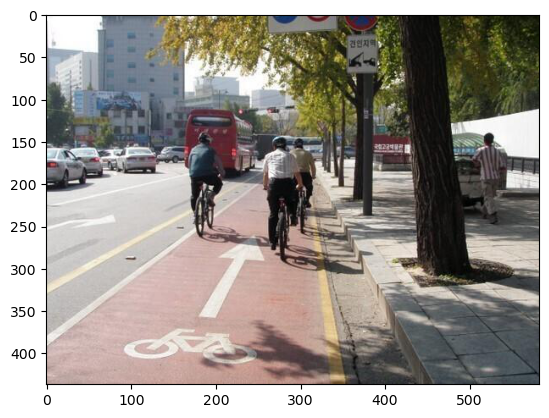

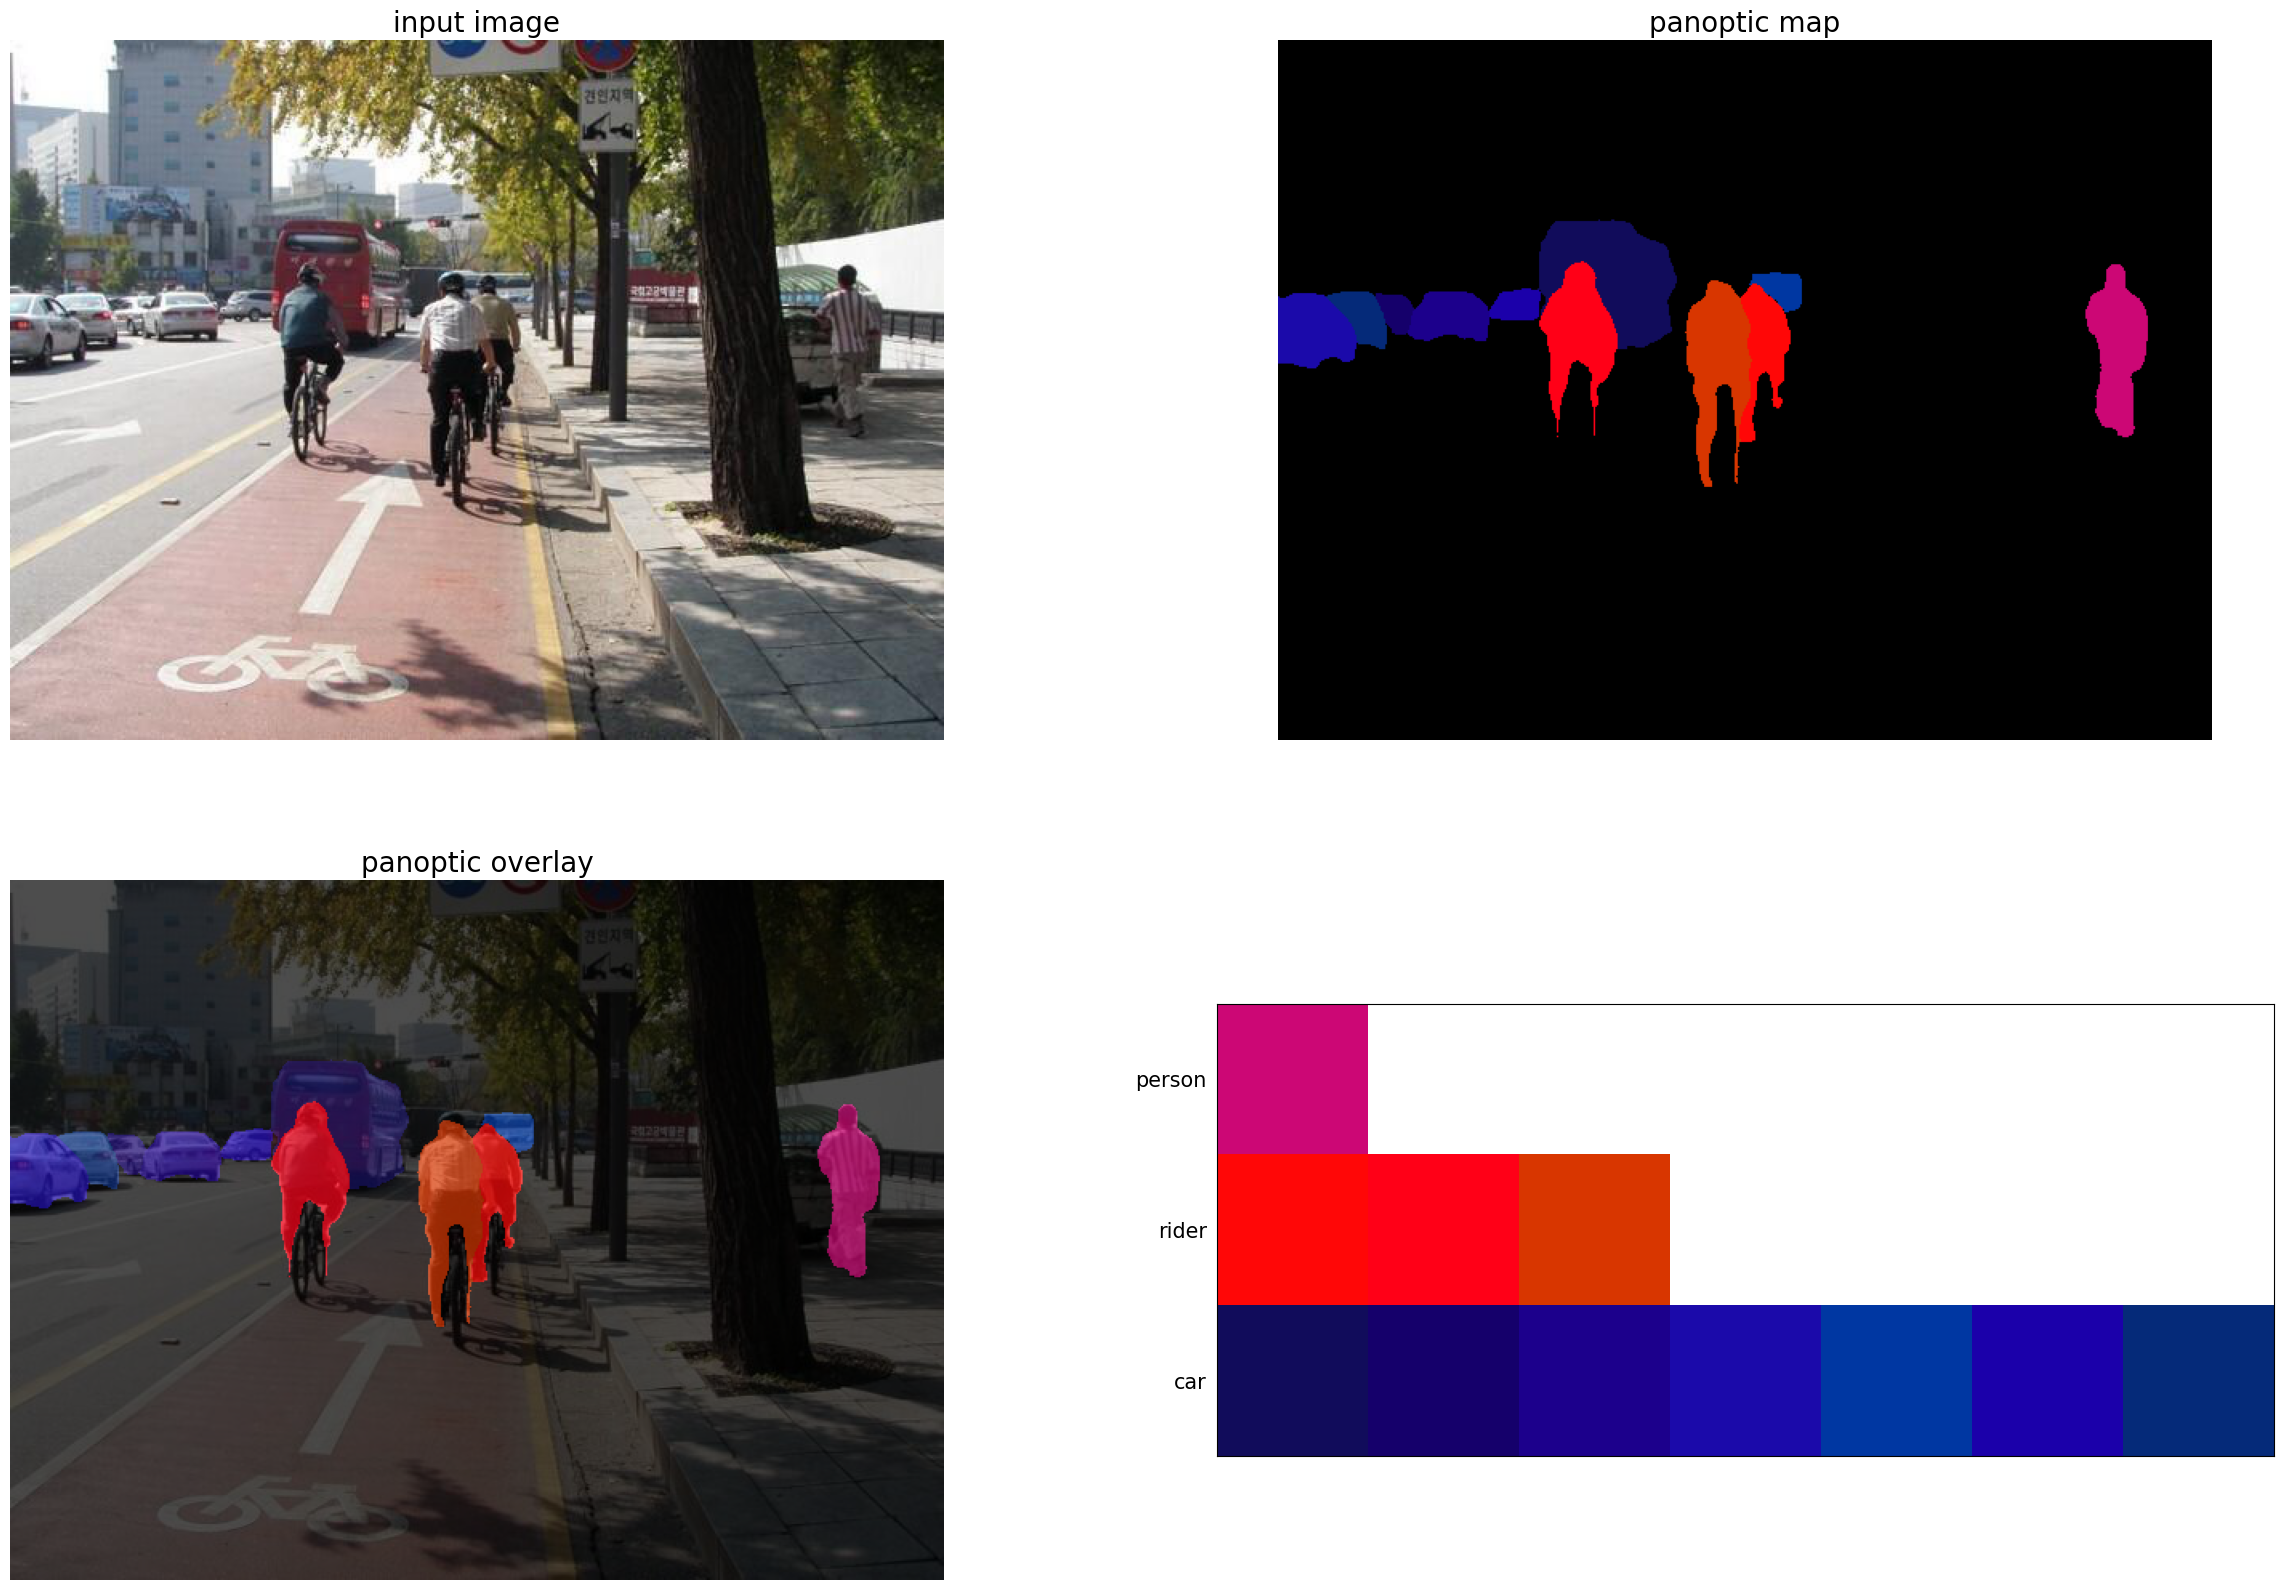

['person', 'rider', 'car'] [1, 3, 7] [0.93051666, 0.9521145, 0.9642404]
panoptic연산완료
['person', 'rider', 'car']
<class 'list'>
[1, 3, 7]
<class 'list'>
[0.93051666, 0.9521145, 0.9642404]
<class 'list'>
b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\x08\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\xb5\x02G\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZ

ValueError: invalid literal for int() with base 10: ''

In [5]:
################################ 이미지 소켓 ##########################

import jpysocket
import socket
import io
from PIL import Image
from PIL import ImageFile
import matplotlib.pyplot as plt


while True:
    select_object=[]
    list_recv_socket=socket.socket(socket.AF_INET,socket.SOCK_STREAM)
    list_recv_socket.bind(('172.30.1.63',1234))
    list_recv_socket.listen(10)
    print("listen~~~~~~")
    list_socket_ct, addr = list_recv_socket.accept()
    byte_list_data = list_socket_ct.recv(1024)
    list_socket_ct.close()
    
    int_list = list(map(int,byte_list_data.decode().split(",")))
    #print("int_list",int_list)
    select_object = int_list
    
    
    host='172.30.1.63' #Host Name
    port=12345    #Port Number
    s=socket.socket() #Create Socket
    s.bind((host,port)) #Bind Port And Host
    s.listen(5) #Socket is Listening

    print("Socket Is Listening....")
    connection,address=s.accept() #Accept the Connection
    print("Connected To ",address)

    msgrecv=connection.recv(65536) #Recieve msg
    #msgrecv=jpysocket.jpydecode(msgrecv) #Decript msg
    print("From Client: ",msgrecv)


    data = msgrecv
    # io.BytesIO 클래스 =  바이트 배열을 이진 파일로 다룰 수 있게 해주는 클래스
    data_io = io.BytesIO(data)
    img = Image.open(data_io)
    print(data_io)
    print(img.size)
    print(type(img))
    print(img)
    # data = bytes, data_io = bytesio


    ImageFile.LOAD_TRUNCATED_IMAGES = True

    plt.imshow(img)

    frame = np.array(img)
    print(frame)
    print(frame.shape)

    # frame = pickle.loads() 
    # frame = cv2.imdecode(frame,cv2.COLOR_BGR2RGB)


    output = LOADED_MODEL(tf.cast(frame, tf.uint8))
    panoptic_map, used_colors,class_list,count_list,score_list = vis_segmentation(frame, output['panoptic_pred'][0], DATASET_INFO,output,select_object)   
    print("panoptic연산완료")

    print(class_list)
    print(type(class_list))
    print(count_list)
    print(type(count_list))
    print(score_list)
    print(type(score_list))

    result_img = Image.fromarray(panoptic_map)
    b = io.BytesIO()
    result_img.save(b, 'jpeg')
    result_bytes=b.getvalue()
    print(result_bytes)

    connection.send(result_bytes)

    class_string = " ".join(class_list)
    count_string = " ".join(map(str,count_list))
    score_string = " ".join(map(str,score_list))
    print("class_string: "+class_string)
    print("count_string: "+count_string)
    print("score_string: "+score_string)

    all_string = class_string +"/"+count_string +"/" + score_string
    print("all_string: " + all_string)
    print(type(all_string))


    # msgsend=jpysocket.jpyencode(byte_im)
    #connection.send(byte_im)

    #msgsend=jpysocket.jpyencode(data) #Encript The Msg
    #connection.send(msgsend) #Send Msg

    s.close() #Close connection
    print("Connection Closed.")

    host='172.30.1.63' #Host Name
    port=123  #Port Number
    s=socket.socket() #Create Socket
    s.bind((host,port)) #Bind Port And Host
    s.listen(5) #Socket is Listening
    print("Socket Is Listening....")
    connection,address=s.accept() #Accept the Connection
    print("Connected To ",address)

    # al_string = bytes(all_string, 'utf-8')
    # print(al_string)
    # print(type(al_string))
    # connection.send(al_string) #Send Msg

    allsend = all_string.encode('utf-8')
    print(type(allsend))
    print(allsend)
    connection.send(allsend)
    print("전송완료")

    s.close() #Close connection
    #print("Connection Closed.")
